In [3]:
import random
! pip install river

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 1.6 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 3.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.

[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [14]:
# 2 concepts = drift
import random
import pandas as pd

THRESHOLD_1 = 4 #7
THRESHOLD_2 = 8 # 9.5
N = 5_000

v1s = []
v2s = []
v3s = []
targets = []

for i in range(2*N):
  v1 = random.randint(0,10)
  v2 = random.randint(0,10)
  v3 = random.randint(0,10)

  v1s.append(v1)
  v2s.append(v2)
  v3s.append(v3)

  if i < N:
    if v1 + v2 >= THRESHOLD_1:
      targets.append(1)
    else:
      targets.append(0)
  else:
    if v1 + v2 >= THRESHOLD_2:
      targets.append(1)
    else:
      targets.append(0)


X = pd.DataFrame({'v1':v1s, 'v2':v2s, 'v3':v3s, 'y':targets})
y = X.pop('y')

In [15]:
from river import stream

for xi, yi in stream.iter_pandas(X, y):
  print(xi, yi)
  break

{'v1': 4, 'v2': 0, 'v3': 7} 1


In [30]:
from river import linear_model

model = linear_model.LogisticRegression()

In [27]:
from river import tree

model = tree.HoeffdingAdaptiveTreeClassifier(
  grace_period=100,
  delta=1e-5,
  # leaf_prediction='nb',
  # nb_threshold=10,
  # seed=0
)

In [31]:
# prequential
# prequential slaiding window
# prequential faiding


from river.drift import PageHinkley

ph = PageHinkley()

preds = []
preq = []
soma = 0

ALPHA = 0.99
preq_a = []
soma_a = 0
nr_a = 0

WINDOW = 500
preq_w = []
soma_w = 0

i = 0
for xi, yi in stream.iter_pandas(X, y):
  pred = model.predict_one(xi)
  error = 1
  if pred == yi:
    error = 0

  preds.append(error)
  soma += error
  preq.append(soma/(i+1))

  soma_a = error + ALPHA * soma_a
  nr_a = 1 + ALPHA * nr_a
  preq_a.append(soma_a/nr_a)

  soma_w += error
  if i > WINDOW:
    soma_w = soma_w - preds[i - WINDOW]
    preq_w.append(soma_w/WINDOW)
  else:
    preq_w.append(soma_w/(i+1))

  ph.update(x=error)
  if ph.drift_detected:
    print(f"Drift for i= {i} and error= {error}")

  model.learn_one(xi, yi)

  i += 1


Drift for i= 5407 and error= 1


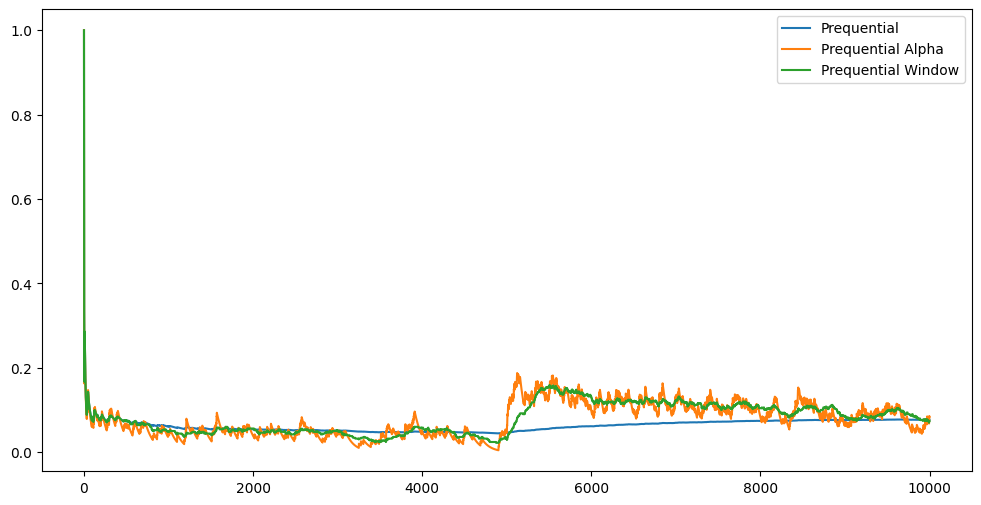

In [32]:
# visualise tree

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(N*2), preq, label='Prequential')
ax.plot(range(N*2), preq_a, label='Prequential Alpha')
ax.plot(range(N*2), preq_w, label='Prequential Window')
ax.legend()
plt.show()